# HELTH INSURANCE CROSS SELL PREDICTION

## Cross Sell and Up Sell

### Cross Sell

Cross-selling is the action or practice of selling an additional product or service to an existing customer. In practice, businesses define cross-selling in many different ways. Elements that might influence the definition might include the size of the business, the industry sector it operates within and the financial motivations of those required to define the term.
The objective of cross-selling can be either to increase the income derived from the client or to protect the relationship with the client or clients. The approach to the process of cross-selling can be varied.
Unlike the acquiring of new business, cross-selling involves an element of risk that existing relationships with the client could be disrupted. For that reason, it is important to ensure that the additional product or service being sold to the client or clients enhances the value the client or clients get from the organization.
In practice, large businesses usually combine cross-selling and up-selling techniques to increase revenue.

### Up sell

Upselling is a sales technique where a seller invites the customer to purchase more expensive items, upgrades, or other add-ons to generate more revenue. While it usually involves marketing more profitable services or products, it can be simply exposing the customer to other options that were perhaps not considered (A different technique is cross-selling in which a seller tries to sell something else). In practice, large businesses usually combine upselling and cross-selling to maximize revenue.

### Upselling vs Cross-selling

Upselling is the practice in which a business tries to motivate customers to purchase a higher-end product, an upgrade, or an additional item in order to make a more profitable sale. For instance, a salesperson may influence a customer into purchasing the newest version of an item, rather than the less-expensive current model, by pointing out its additional features. A similar marketing technique is cross-selling, where the salesperson suggests the purchase of additional products for sale. For example, he might say "Would you like some ice cream to go with that cake?" Both techniques increase profits for businesses, but research has shown that upselling is generally more effective than cross-selling. Cross-selling means to offer more services to existing customer and upselling means enhance sale by describing features of new product.

## Context
### The Insurance All Company ###
Disclaimer: The following context is completely fictional, the company, the context, the CEO, the business questions exist only in my imagination.

Insurance All is an Insurance company that has provided Health Insurance to its customers and the product team is analyzing the possibility of offering policyholders a new product: Vehicle Insurance.

As with health insurance, customers of this new Vehicle Insurance plan need to pay an amount annually to Insurance All to obtain an amount insured by the company, aimed at the costs of an eventual accident or damage to the vehicle.

Insurance All conducted a survey of about 380,000 customers about their interest in joining a new auto insurance product last year. All customers expressed interest or not in purchasing auto insurance and these responses were saved in a database along with other customer attributes.

The product team selected 127 thousand new customers who did not respond to the survey to participate in a campaign, in which they will receive the offer of the new auto insurance product. The offer will be made by the sales team through telephone calls.

However, the sales team has the capacity to make 20 thousand calls within the campaign period.

### The challenge ###
In that context, you were hired as a Data Science consultant to build a model that predicts whether or not the customer would be interested in auto insurance.

With its solution, the sales team hopes to be able to prioritize the people with the greatest interest in the new product and, thus, optimize the campaign by making only contacts with customers most likely to make the purchase.

As a result of your consultancy, you will need to deliver a report containing some analysis and answers to the following questions:

- Main insights on the most relevant attributes of customers interested in purchasing auto insurance.

- What percentage of customers interested in purchasing auto insurance will the sales team be able to reach by making 20,000 calls?

- And if the sales team's capacity increases to 40,000 calls, what percentage of customers interested in purchasing auto insurance will the sales team be able to contact?

- How many calls does the sales team need to make to contact 80% of customers interested in purchasing auto insurance?

# 0.0 SETUP

## 0.1 Imports

In [156]:
import psycopg2 as pg
import pandas as pd
import numpy as np
import pandas.io.sql as psql
import seaborn             as sns
import matplotlib.pyplot   as plt
import matplotlib.gridspec as gridspec
from IPython.display       import Image
import warnings
warnings.filterwarnings( 'ignore' )

from IPython.core.display  import HTML
from scipy                 import stats     as ss
from scipy.stats           import pointbiserialr, chi2_contingency

# Rescaling Features
from sklearn.preprocessing     import MinMaxScaler, LabelEncoder

# Feature Selection
from boruta                    import BorutaPy
from sklearn.ensemble          import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn import ensemble        as en

# Machine Learning
from sklearn.model_selection import train_test_split
from imblearn.combine        import SMOTETomek
from sklearn.linear_model    import LogisticRegression, SGDClassifier
from catboost                import CatBoostClassifier
from lightgbm                import LGBMClassifier
from xgboost                 import XGBClassifier
from imblearn.ensemble       import BalancedRandomForestClassifier

# metrics
from random            import choices as rchoice
from sklearn.metrics   import accuracy_score, precision_score, recall_score
from sklearn.metrics   import roc_auc_score, f1_score, cohen_kappa_score, roc_curve
from sklearn.metrics   import precision_recall_curve, classification_report, brier_score_loss

# cross validation
from sklearn.model_selection import cross_val_score, StratifiedKFold, RepeatedStratifiedKFold 

# confusion matrix
from sklearn.metrics import plot_confusion_matrix

#fine tuning
from numpy                   import argmax
#from skopt                   import BayesSearchCV
from sklearn.model_selection import GridSearchCV

## 0.2 Helper Functions

In [2]:
# Jupyter Settings
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['font.size'] = 25
    
    display( HTML( '<style>.container { width:80% !important; }</style>') )
    pd.set_option('display.float_format', lambda x: '%.5f' % x)
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [3]:
def descriptive_statistics (num_df):
    # Central Tendency - mean, median
    ct1 = pd.DataFrame(num_df.apply(np.mean)).T
    ct2 = pd.DataFrame(num_df.apply(np.median)).T

    # Dispersion - Std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(num_df.apply(np.std)).T
    d2 = pd.DataFrame(num_df.apply(min)).T
    d3 = pd.DataFrame(num_df.apply(max)).T
    d4 = pd.DataFrame(num_df.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_df.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_df.apply(lambda x: x.kurtosis())).T

    # Concatenate
    m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    return m

In [4]:
def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0,chi2 - (k - 1) * (r - 1) / (n - 1))
    
    kcorr = k - (k - 1) ** 2/ (n - 1) 
    rcorr = r - (r - 1) ** 2/ (n - 1) 
    
    v = np.sqrt( (chi2corr / n) / (min (kcorr - 1,rcorr - 1)))
    return v   

In [90]:
def feature_selection(model, X, y):
    model.fit(X, y)
        
    # Feature importance data frame
    feat_imp = pd.DataFrame({'feature': X.columns,
                             'feature_importance': model.feature_importances_}) \
                             .sort_values('feature_importance', ascending = False) \
                             .reset_index(drop = True)
        
    # Plot feature importance
    plt.figure(figsize = (12,6))
    sns.barplot(x = 'feature_importance', y = 'feature', data = feat_imp, orient = 'h', palette = 'winter_r')
    plt.title(type (model).__name__, size = 16)
    plt.yticks(size = 13)
    plt.xticks(size = 13)
    plt.xlabel('Feature Importance', size = 16, color = 'grey')
    plt.ylabel('Features', size = 16, color = 'grey')

In [91]:
def ml_performance(models, X_train, y_train, X_valid, y_valid, threshold):
    model_df = []     
    for model in models:
        print("Training " + type(model).__name__ + "...")
        model.fit(X_train, y_train)
        
        # prediction positive probabilities according to a threshold
        y_proba = model.predict_proba(X_valid)[:, 1]
        y_hat = (y_proba >= threshold).astype(int)
        
        # metrics
        f1 = f1_score(y_valid, y_hat)
        accuracy = accuracy_score(y_valid, y_hat)
        kappa = cohen_kappa_score(y_valid, y_hat)
        roc_auc = roc_auc_score(y_valid, y_hat)
        precision = precision_score(y_valid, y_hat)
        recall = recall_score(y_valid, y_hat)
        brier = brier_score_loss(y_valid, y_hat, pos_label=1)
        
        metrics = pd.DataFrame({'Model Name': type(model).__name__,'Accuracy': accuracy,'Precision': precision,
                                'Recall': recall,'F1-Score': f1,'ROC-AUC': roc_auc,'Kappa': kappa,
                                'Brier': brier}, index = [0]).sort_values('F1-Score', ascending = False)
        
        model_df.append(metrics)
        final_model = pd.concat(model_df)
    return final_model.sort_values('F1-Score', ascending = False).round(5)

In [92]:
def cross_validation(models, X, y, cv):
    cv_df = []
    for n in models:
        accuracy_cv = cross_val_score(n, X, y, cv = cv, scoring='accuracy', n_jobs=-1)
        accuracy = "{:.4f} +/- %{:.4f}".format(accuracy_cv.mean(), accuracy_cv.std())
        prec_cv = cross_val_score(n, X, y, cv = cv, scoring='precision', n_jobs=-1)
        prec = "{:.4f} +/- %{:.4f}".format(prec_cv.mean(), prec_cv.std())
        recall_cv = cross_val_score(n, X, y, cv = cv, scoring='recall', n_jobs=-1)
        recall = "{:.4f} +/- %{:.4f}".format(recall_cv.mean(), recall_cv.std())
        f1_score_cv = cross_val_score(n, X, y, cv = cv, scoring='f1', n_jobs=-1)
        f1_score = "{:.4f} +/- %{:.4f}".format(f1_score_cv.mean(), f1_score_cv.std())
        roc_auc_cv = cross_val_score(n, X, y, cv = cv, scoring='roc_auc', n_jobs=-1)
        roc_auc = "{:.4f} +/- %{:.4f}".format(roc_auc_cv.mean(), roc_auc_cv.std())
        
                
        A = pd.DataFrame( {'Model Name': type(n).__name__,
                           'Accuracy (Avg+Std)': accuracy,
                           'Precision (Avg+Std) ': prec,
                           'Recall (Avg+Std) ': recall,
                           'F1-Score (Avg+Std)': f1_score,
                           'ROC-AUC (Avg+Std)': roc_auc }, index = [0])
    
        cv_df.append(A)
        final_df = pd.concat(cv_df)

    return final_df

## 0.3 Loading Data

In [115]:
host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
port = '5432'
database = 'comunidadedsdb'
username = 'member'
password = 'cdspa'

### 0.3.1 Schema Query

In [116]:
try:
    conn = pg.connect("dbname=comunidadedsdb user=member password=cdspa host=comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com port=5432")

except:
    print ("Unable to connect to the database.")
    
cursor = conn.cursor()
query_schema = "SELECT nspname FROM pg_catalog.pg_namespace"

try:
    cursor.execute(query_schema)

except:
    print ("Can't drop our test database!")

record = cursor.fetchall()
print(record)

cursor.close()
conn.close()

[('pg_toast',), ('pg_temp_1',), ('pg_toast_temp_1',), ('pg_catalog',), ('information_schema',), ('public',), ('pa004',), ('pg_temp_4',), ('pg_toast_temp_4',), ('pa005',), ('pg_temp_9',), ('pg_toast_temp_9',)]


### 0.3.2 Table Query

In [117]:
try:
    conn = pg.connect("dbname=comunidadedsdb user=member password=cdspa host=comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com port=5432")

except:
    print ("Unable to connect to the database.")
    
cursor = conn.cursor()
query_tables = "SELECT tablename FROM pg_tables WHERE schemaname='pa004'"

try:
    cursor.execute(query_tables)

except:
    print ("Can't drop our test database!")

record = cursor.fetchall()
print(record)

cursor.close()
conn.close()

[('users',), ('vehicle',), ('insurance',)]


### 0.3.3 Collect Data

In [120]:
conn = pg.connect("dbname=comunidadedsdb user=member password=cdspa host=comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com port=5432")

query_all_tables = """
                  SELECT U.id, U.gender, U.age, U.region_code, U.policy_sales_channel, 
                             I.previously_insured, I.annual_premium, I.vintage,
                             V.driving_license, V.vehicle_age, V.vehicle_damage,
                             I.response
                  FROM pa004.users U LEFT JOIN pa004.insurance I ON U.id = I.id
                                     LEFT JOIN pa004.vehicle   V ON U.id = V.id"""

In [121]:
df1 = pd.read_sql( query_all_tables, conn )
conn.close()

# 1.0 DATA DESCRIPTION

In [123]:
df1.head()

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,driving_license,vehicle_age,vehicle_damage,response
0,7,Male,23,11.00000,152.00000,0,23367.00000,249,1,< 1 Year,Yes,0
1,13,Female,41,15.00000,14.00000,1,31409.00000,221,1,1-2 Year,No,0
2,18,Female,25,35.00000,152.00000,1,46622.00000,299,1,< 1 Year,No,0
3,31,Female,26,8.00000,160.00000,0,2630.00000,136,1,< 1 Year,No,0
4,39,Male,45,8.00000,124.00000,0,42297.00000,264,1,1-2 Year,Yes,0


## 1.1 Features Description

The data set includes the following information:

**Id:** customer's unique identifier.

**Gender:** gender of the client.

**Age:** age of the customer.

**Driving License:** 0, the customer is not allowed to drive and 1, the customer is allowed to drive (CNH - National Driver's License).

**Region Code:** code of the customer's region.

**Previously Insured:** 0, the customer does not have auto insurance and 1, the customer already has auto insurance.

**Vehicle Age:** age of the vehicle.

**Vehicle Damage:** 0, customer has never had his vehicle damaged in the past and 1, customer has had his vehicle damaged in the past.

**Annual Premium:** amount the customer paid the company for annual health insurance.

**Policy sales channel:** anonymous code for the customer contact channel.

**Vintage:** number of days the customer joined the company through the purchase of health insurance.

**Response:** 0, the customer is not interested and 1, the customer is interested.

## 1.2 Data Dimentions

In [124]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 381109
Number of cols: 12


## 1.3 Data Types

In [125]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
previously_insured        int64
annual_premium          float64
vintage                   int64
driving_license           int64
vehicle_age              object
vehicle_damage           object
response                  int64
dtype: object

## 1.4 Check NA

In [126]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
previously_insured      0
annual_premium          0
vintage                 0
driving_license         0
vehicle_age             0
vehicle_damage          0
response                0
dtype: int64

## 1.5 Change Types

In [127]:
df1['region_code'] = df1['region_code'].astype(int)
df1['policy_sales_channel'] = df1['policy_sales_channel'].astype(int)
df1['annual_premium'] = df1['annual_premium'].astype(int)
df1['region_code'] = df1['region_code'].astype(int)

# Vehicle damage
df1['vehicle_damage'] = df1['vehicle_damage'].apply( lambda x: 1 if x == 'Yes' else 0)

In [128]:
df1.dtypes

id                       int64
gender                  object
age                      int64
region_code              int32
policy_sales_channel     int32
previously_insured       int64
annual_premium           int32
vintage                  int64
driving_license          int64
vehicle_age             object
vehicle_damage           int64
response                 int64
dtype: object

**Data types :** int64 (5), int32 (3) and object (3)

## 1.6 Descriptive Statistical

In [129]:
num_attributes = df1.select_dtypes(include = ['int64', 'int32'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'int32'])

### 1.6.1 Numerical Attributes

In [130]:
descriptive_statistics(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.00000,381109.00000,381108.00000,190555.00000,190555.00000,110016.69187,-0.00000,-1.20000
1,age,20.00000,85.00000,65.00000,38.82258,36.00000,15.51159,0.67254,-0.56566
2,region_code,0.00000,52.00000,52.00000,26.38881,28.00000,13.22987,-0.11527,-0.86786
3,policy_sales_channel,1.00000,163.00000,162.00000,112.03429,133.00000,54.20392,-0.90001,-0.97081
4,previously_insured,0.00000,1.00000,1.00000,0.45821,0.00000,0.49825,0.16775,-1.97187
5,annual_premium,2630.00000,540165.00000,537535.00000,30564.38958,31669.00000,17213.13247,1.76609,34.00457
6,vintage,10.00000,299.00000,289.00000,154.34740,154.00000,83.67119,0.00303,-1.20069
7,driving_license,0.00000,1.00000,1.00000,0.99787,1.00000,0.04611,-21.59518,464.35430
8,vehicle_damage,0.00000,1.00000,1.00000,0.50488,1.00000,0.49998,-0.01951,-1.99963
9,response,0.00000,1.00000,1.00000,0.12256,0.00000,0.32794,2.30191,3.29879


### 1.6.2 Categorical Attributes

In [131]:
cat_attributes.apply( lambda x: x.unique().shape[0])

gender         2
vehicle_age    3
dtype: int64

<AxesSubplot:xlabel='vehicle_age', ylabel='response'>

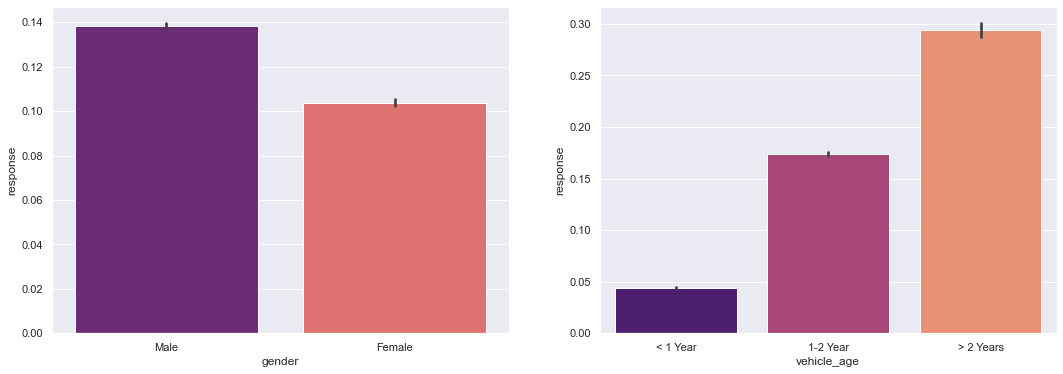

In [19]:
plt.figure(figsize = (18, 6))

plt.subplot(1,2,1)
sns.barplot(x = 'gender', y = 'response', data = df1, palette = "magma" )

plt.subplot(1,2,2)
sns.barplot(x = 'vehicle_age', y = 'response', data = df1 , palette = "magma")

# 2.0 FEATURE ENGENEERING

In [132]:
df2 = df1.copy()

## 2.1 Mind Map Hypotheses

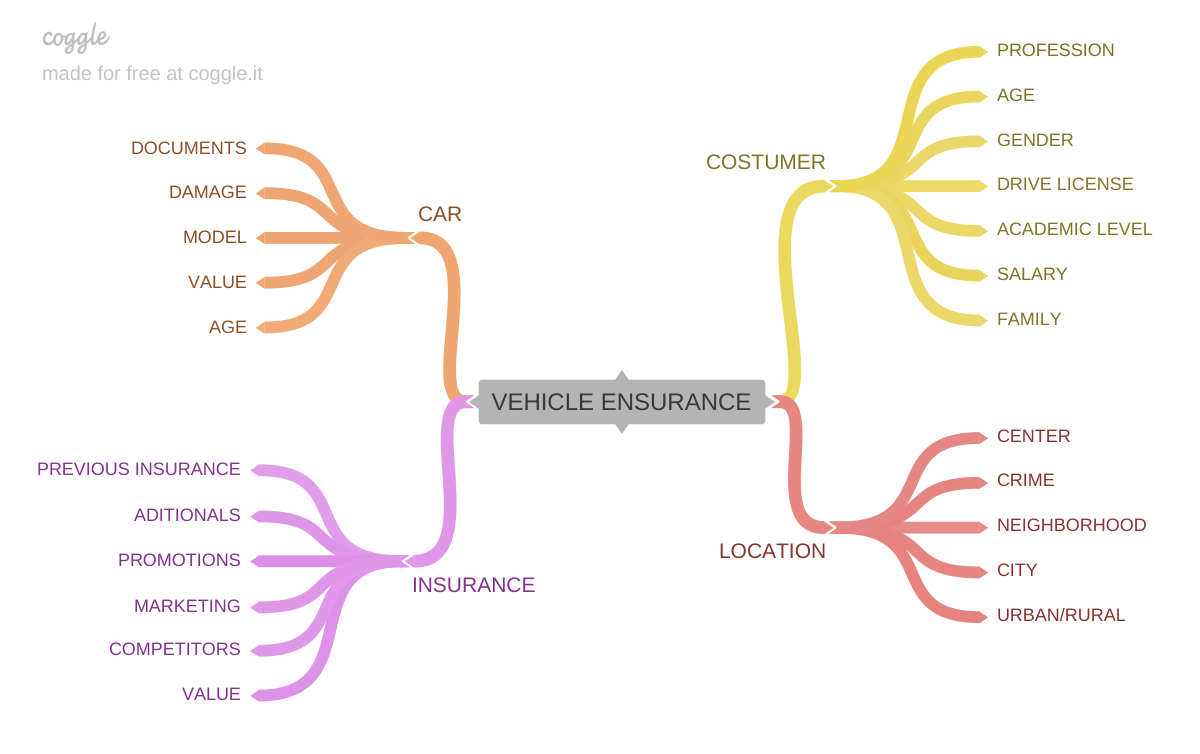

In [21]:
Image ('img/VEHICLE_ENSURANCE.png')

## 2.2 Hypotheses criation

### 2.2.1 Hypotheses Costumer

**1.** Customers with high-paying jobs should want more a motor ensurance.

**2.** Older customers should want more a motor ensurance.

**3.** Female customers should want more a motor ensurance.

**4.** Customers without drive license shouldn't want a motor ensurance.

**5.** Customers with high academy level should want more a motor ensurance.

**6.** Customers with family should want more a motor ensurance.

**7.** Customers with high number of children should want more a motor ensurance.

**8.** Customers with high Annual Premium should want more a motor ensurance.

### 2.2.2 Hypotheses Location

**1.** Customers that lives on city centers should want more a motor ensurance.

**2.** Customers living in a violent region should want more a motor ensurance.

**3.** Customers living in a poor neighborhood should want more a motor ensurance.

**4.** Customers living in big cities should want more a motor ensurance.

**5.** Customers living in the countryside shouldn't want a motor ensurance.

**6.** Customers who live in regions with more demage rate should want auto insurance.

### 2.2.3 Hypotheses Car

**1.** Customers with cars without documents shouldn't want a motor ensurance.

**2.** Customers that had previous acidents should want more a motor ensurance.

**3.** Customers who own a more expensive car model should want more a motor ensurance.

**4.** ustomers who own a more stolen car model should want more car insurance.

**5.** Customers who own a more expensive car should want more motor insurance.

**6.** Customers who own a newer car should want more auto insurance.

### 2.2.4 Hypotheses Insurance

**1.** Customers that had a previous auto ensurance should want more a motor ensurance.

**2.** Motor insurance with additional offers should sell more.

**3.** Motor insurance in promotions offers should sell more.

**4.** Motor insurance with a good marketing should sell more.

**5.** Motor insurance with less competitors should sell more.

**6.** Motor insurance with lower values should sell more.

**7.** Customers who use life insurance more, should want auto insurance

## 2.3 Hypotheses final list

**1.** Older customers should want more a motor ensurance.

**2.** Female customers should want more a motor ensurance.

**3.** Customers without drive license shouldn't want a motor ensurance.

**4.** Customers with high Annual Premium should want more a motor ensurance.

**5.** Customers that lives on city centers should want more a motor ensurance.

**6.** Customers that had previous acidents should want more a motor ensurance.

**7.** Customers who own a newer car should want more auto insurance.

**8.** Customers that had a previous auto ensurance should want more a motor ensurance.

**9.** Customers who use life insurance more, should want auto insurance.

**10.** Customers who live in regions with more demage rate should want auto insurance.

## 2.4 Hypotheses for Future Analysis

**1.** Customers with high-paying jobs should want more a motor ensurance.

**2.** Customers with high academy level should want more a motor ensurance.

**3.** Customers with family should want more a motor ensurance.

**4.** Customers with high number of children should want more a motor ensurance.

**5.** Customers living in a violent region should want more a motor ensurance.

**6.** Customers living in a poor neighborhood should want more a motor ensurance.

**7.** Customers living in big cities should want more a motor ensurance.

**8.** Customers living in the countryside shouldn't want a motor ensurance.

**9.** Customers with cars without documents shouldn't want a motor ensurance.

**10.** Customers who own a more expensive car model should want more a motor ensurance.

**11.** ustomers who own a more stolen car model should want more car insurance.

**12.** Customers who own a more expensive car should want more motor insurance.

**13.** Motor insurance with additional offers should sell more.

**14.** Motor insurance in promotions offers should sell more.

**15.** Motor insurance with a good marketing should sell more.

**16.** Motor insurance with less competitors should sell more.

**17.** Motor insurance with lower values should sell more.

## 2.5 Feature Engineering

In [133]:
df2.head()

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,driving_license,vehicle_age,vehicle_damage,response
0,7,Male,23,11,152,0,23367,249,1,< 1 Year,1,0
1,13,Female,41,15,14,1,31409,221,1,1-2 Year,0,0
2,18,Female,25,35,152,1,46622,299,1,< 1 Year,0,0
3,31,Female,26,8,160,0,2630,136,1,< 1 Year,0,0
4,39,Male,45,8,124,0,42297,264,1,1-2 Year,1,0


In [134]:
# Creating Damage por region code index
damage_per_rcode = df2[['vehicle_damage']].groupby(df2['region_code']).mean().reset_index()
damage_per_rcode = damage_per_rcode.rename( columns = {'vehicle_damage' : 'damage_per_rcode'})
df2 = df2.merge(damage_per_rcode, on = 'region_code', how = 'left')
df2['damage_per_rcode'] = df2['damage_per_rcode'].astype(np.float64)

# 3.0 VARIABLE FILTERING

In [135]:
df3 = df2.copy()

## 3.1 Columns Selection

In [136]:
#cols_drop = df3['policy_sales_channel']
df3 = df3.drop('policy_sales_channel', axis = 1)

In [137]:
df3.head()

,id,gender,age,region_code,previously_insured,annual_premium,vintage,driving_license,vehicle_age,vehicle_damage,response,damage_per_rcode
0,7,Male,23,11,0,23367,249,1,< 1 Year,1,0,0.35778
1,13,Female,41,15,1,31409,221,1,1-2 Year,0,0,0.43816
2,18,Female,25,35,1,46622,299,1,< 1 Year,0,0,0.42538
3,31,Female,26,8,0,2630,136,1,< 1 Year,0,0,0.45860
4,39,Male,45,8,0,42297,264,1,1-2 Year,1,0,0.45860


# 4.0 EXPLORATORY DATA ANALYSIS

In [138]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

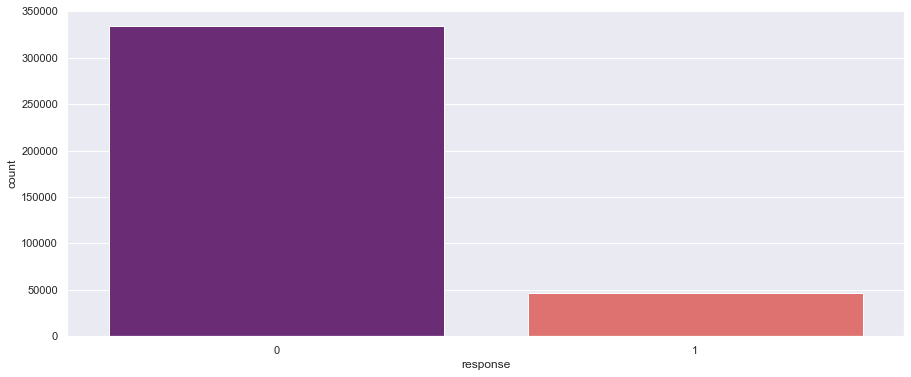

In [28]:
plt.figure(figsize = (15,6))
sns.countplot('response', data = df4, palette = "magma");

### 4.1.2 Numerical Variable

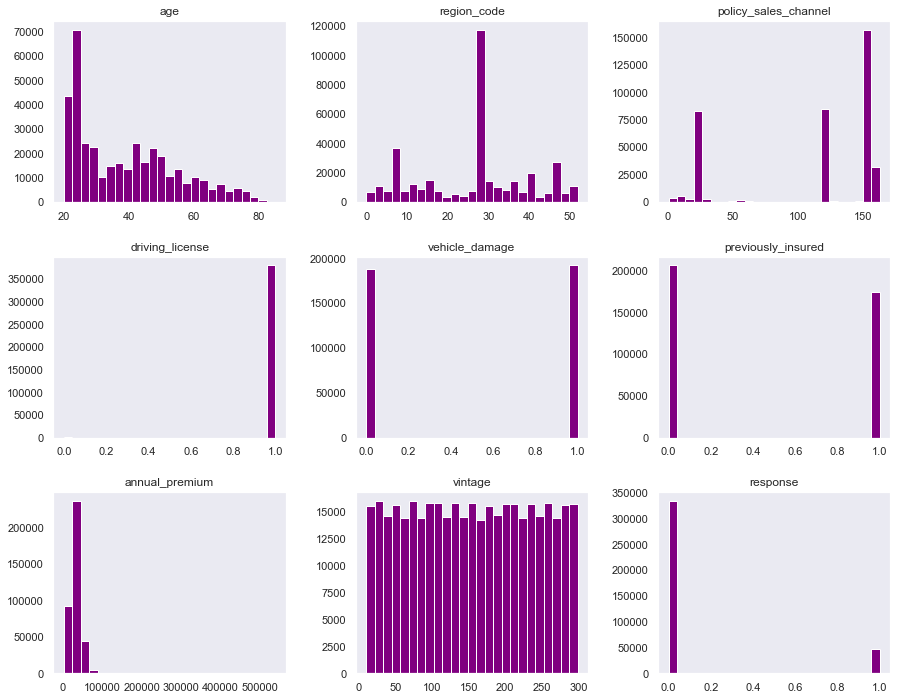

In [29]:
fig = plt.figure(figsize = (15,12))
num_attributes.hist(bins = 25, ax = fig.gca(), grid = False, color = 'purple');

### 4.1.3 Categorical Variable

<AxesSubplot:xlabel='vehicle_age', ylabel='count'>

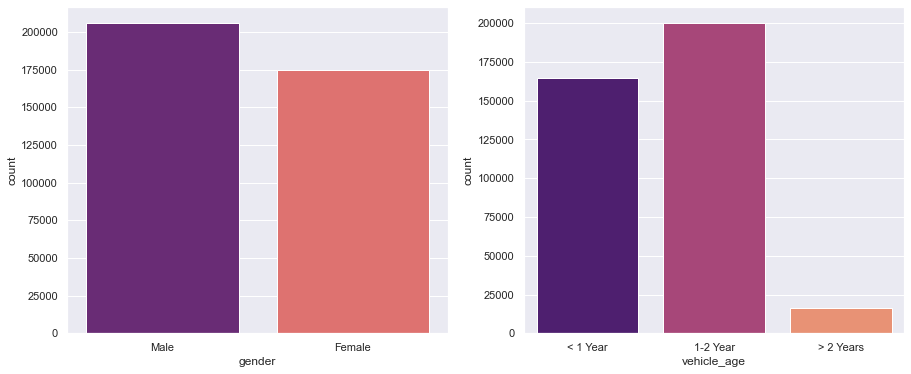

In [30]:
fig = plt.figure(figsize = (15,6))

# gender
plt.subplot (1,2,1)
sns.countplot(df4['gender'], palette = "magma")

# vehicle_age
plt.subplot (1,2,2)
sns.countplot(df4['vehicle_age'], palette = "magma")

## 4.2 Bivariate Analysis

### H1: Older customers should want more a motor ensurance.
**FALSE.** Customers with ages between 30 and 50 years old want more motor ensurance. 

<AxesSubplot:>

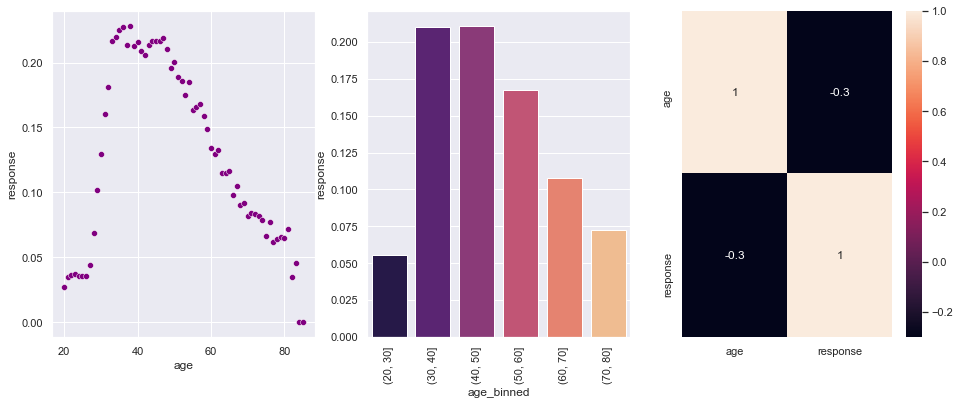

In [31]:
fig = plt.figure(figsize = (16,6))

plt.subplot (1,3,1)
aux1 = df4[['age', 'response']].groupby ('age').mean().reset_index()
sns.scatterplot(x = 'age', y = 'response', data = aux1, color = 'purple')

plt.subplot (1,3,2)
bins = list(np.arange(20, 90, 10))
aux1['age_binned'] = pd.cut (aux1['age'], bins = bins)
aux2 = aux1[['age_binned', 'response']].groupby ('age_binned').mean().reset_index()
sns.barplot(x = 'age_binned', y = 'response', data = aux2, palette = "magma")
plt.xticks(rotation = 90);

plt.subplot (1,3,3)
sns.heatmap(aux1.corr(method= 'pearson'), annot = True)

### H2: Female customers should want more a motor ensurance.
**FALSE.** Males want more motor ensurance then females.

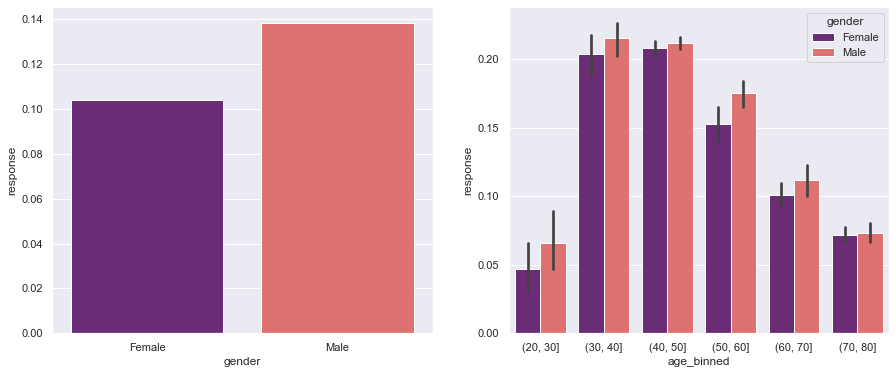

In [32]:
fig = plt.figure(figsize = (15,6))

plt.subplot (1,2,1)
aux1 = df4[['gender', 'response']].groupby('gender').mean().reset_index()
sns.barplot (x = 'gender', y = 'response', data = aux1, palette = "magma")


plt.subplot (1,2,2)
aux2 = df4[['gender', 'age', 'response']].groupby(['age', 'gender']).mean().reset_index()
bins = list(np.arange(20, 90, 10))
aux2['age_binned'] = pd.cut (aux2['age'], bins = bins)
aux3 = aux2[['gender','age_binned', 'response']].groupby ('gender').mean().reset_index()
#aux2 = df4[['age','gender', 'response']].groupby (['age', 'gender']).mean().reset_index()
sns.barplot(x = 'age_binned', y = 'response', hue = 'gender', data = aux2, palette = "magma");

### H3: Customers without drive license shouldn't want a motor ensurance.
**TRUE.** Customers with drive license want more motor ensurance.

<AxesSubplot:>

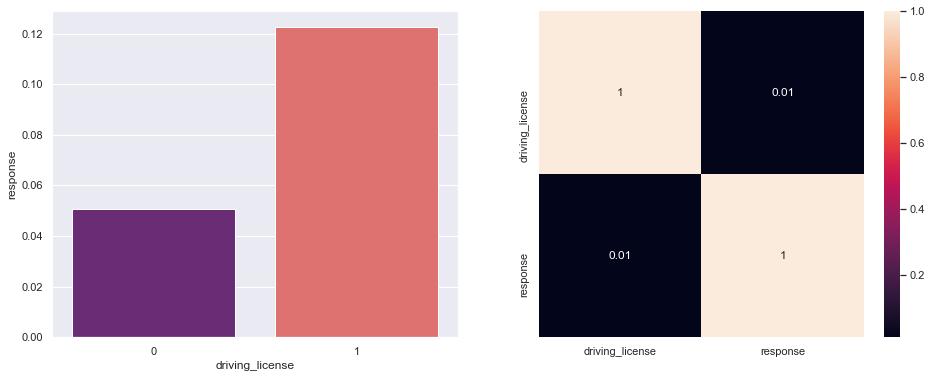

In [33]:
fig = plt.figure(figsize = (16,6))

plt.subplot (1,2,1)
aux1 = df4[['driving_license', 'response']].groupby('driving_license').mean().reset_index()
sns.barplot (x = 'driving_license', y = 'response', data = aux1, palette = "magma")

plt.subplot (1,2,2)
aux2 = df4[['driving_license', 'response']]
sns.heatmap(aux2.corr(method= 'pearson'), annot = True)

### H4: Customers with high Annual Premium should want more a motor ensurance.
**TRUE.** Customers with high Annual Premium want more a motor ensurance.

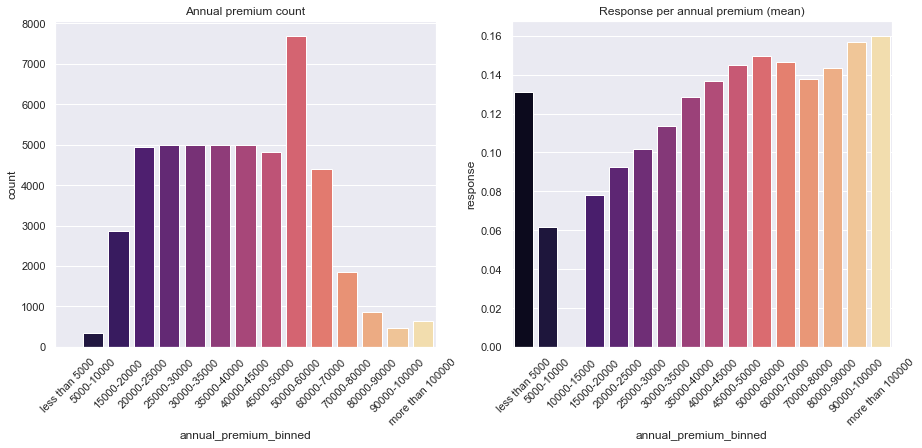

In [34]:
fig = plt.figure(figsize = (15,6))




aux2 = df4[['annual_premium', 'response']].groupby(['annual_premium']).mean().reset_index()
aux2['annual_premium_binned'] = aux2['annual_premium'].apply( lambda x: 'less than 5000' if x < 5000 
                                                              else '5000-10000' if 5000 <= x < 15000 
                                                              else '10000-15000' if 10000 <= x < 15000 
                                                              else '15000-20000' if 15000 <= x < 20000 
                                                              else '20000-25000' if 20000 <= x < 25000 
                                                              else '25000-30000' if 25000 <= x < 30000 
                                                              else '30000-35000' if 30000 <= x < 35000 
                                                              else '35000-40000' if 35000 <= x < 40000 
                                                              else '40000-45000' if 40000 <= x < 45000 
                                                              else '45000-50000' if 45000 <= x < 50000 
                                                              else '50000-60000' if 50000 <= x < 60000 
                                                              else '60000-70000' if 60000 <= x < 70000 
                                                              else '70000-80000' if 70000 <= x < 80000 
                                                              else '80000-90000' if 80000 <= x < 90000 
                                                              else '90000-100000' if 90000 <= x < 100000 
                                                              else 'more than 100000')

plt.subplot (1,2,1)
aux1 = df4[['annual_premium', 'response']].groupby('annual_premium').mean().reset_index()
#sns.scatterplot (x = 'annual_premium', y = 'response', data = aux1)
sns.countplot(aux2['annual_premium_binned'], palette = "magma").set_title('Annual premium count');
plt.xticks(rotation = 45);

plt.subplot (1,2,2)
aux3 = aux2[['annual_premium_binned', 'response']].groupby ('annual_premium_binned').mean().reset_index()

sns.barplot(x = 'annual_premium_binned', y = 'response', data = aux3, 
            order = ['less than 5000','5000-10000','10000-15000','15000-20000', 
                     '20000-25000','25000-30000','30000-35000','35000-40000', 
                     '40000-45000','45000-50000','50000-60000','60000-70000',
                     '70000-80000','80000-90000','90000-100000','more than 100000'], palette = "magma").set_title('Response per annual premium (mean)');
plt.xticks(rotation = 45);

### H5: Customers that lives on city centers should want more a motor ensurance.
**TRUE.** Customers that lives on city centers should want more a motor ensurance.

<AxesSubplot:xlabel='region_code', ylabel='count'>

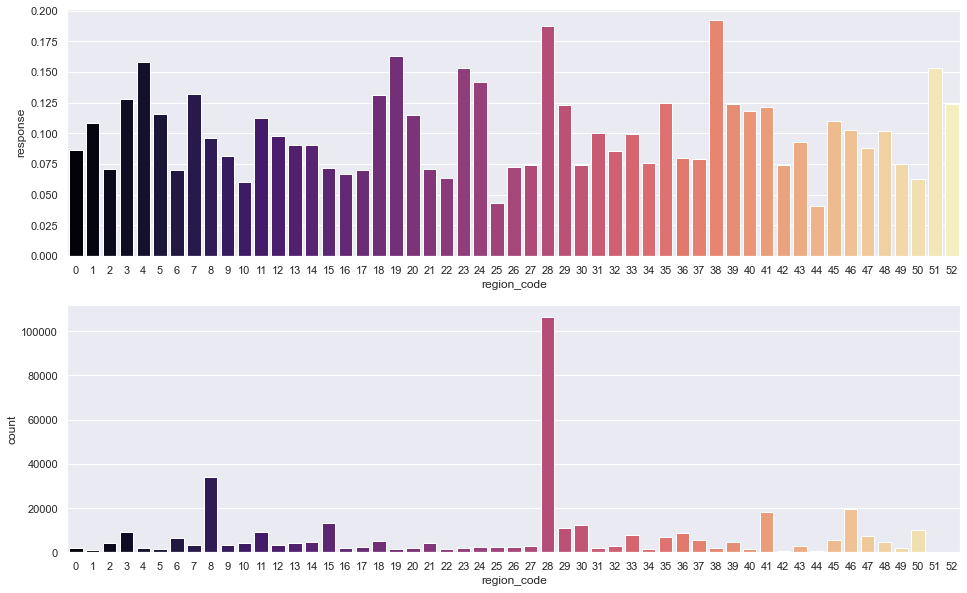

In [35]:
fig = plt.figure(figsize = (16,10))

plt.subplot (2,1,1)
aux1 = df4[['region_code', 'response']].groupby('region_code').mean().reset_index()
sns.barplot (x = 'region_code', y = 'response', data = aux1, palette = "magma")

plt.subplot (2,1,2)
sns.countplot(df4['region_code'], palette = "magma")

### H6: Customers that had previous acidents should want more a motor ensurance.
**TRUE.** Customers that had previous acidents want more a motor ensurance.

<AxesSubplot:xlabel='vehicle_damage', ylabel='response'>

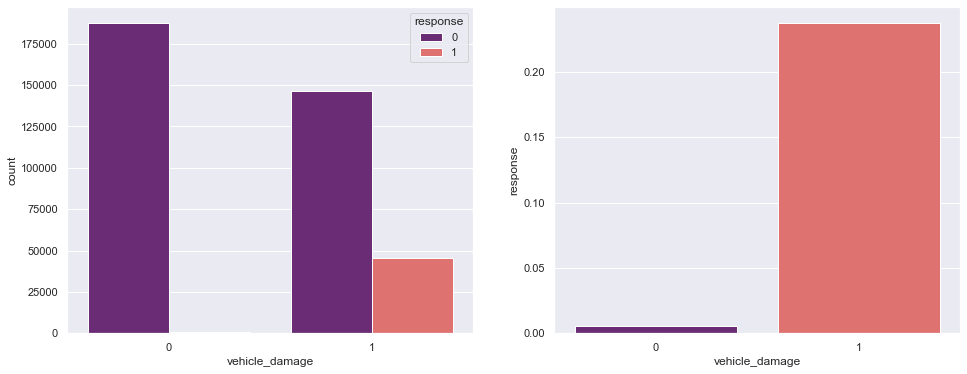

In [36]:
fig = plt.figure(figsize = (16,6))

plt.subplot (1,2,1)
sns.countplot(x = df4['vehicle_damage'], hue = df4['response'], palette = "magma");

plt.subplot (1,2,2)
aux1 = df4[['vehicle_damage', 'response']].groupby('vehicle_damage').mean().reset_index()
sns.barplot (x = 'vehicle_damage', y = 'response', data = aux1, palette = "magma")

### H7: Customers who own a newer cars should want more auto insurance.
**FALSE.** Customers who own a older cars should want more auto insurance.

<AxesSubplot:xlabel='vehicle_age', ylabel='response'>

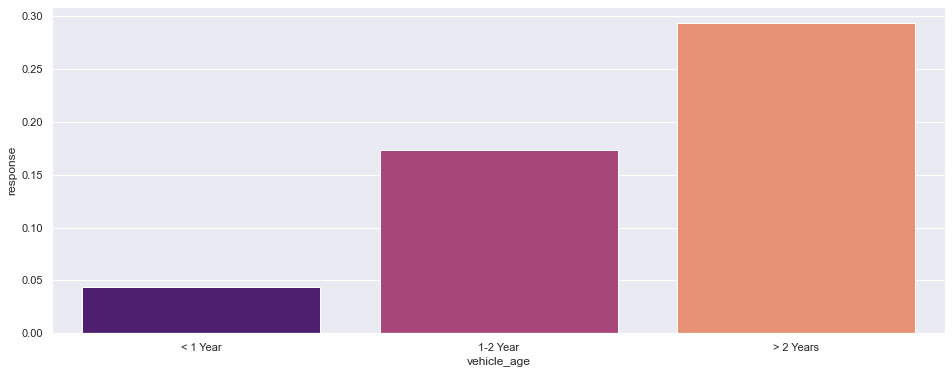

In [37]:
fig = plt.figure(figsize = (16,6))

aux1 = df4[['vehicle_age', 'response']].groupby('vehicle_age').mean().reset_index()
sns.barplot (x = 'vehicle_age', y = 'response', data = aux1, order = ['< 1 Year', '1-2 Year', '> 2 Years'], palette = "magma")

### H8: Customers that had a previous auto ensurance should want more a motor ensurance.
**FALSE.** Customers that had a previous auto ensurance don't want more a motor ensurance.

<AxesSubplot:xlabel='previously_insured', ylabel='response'>

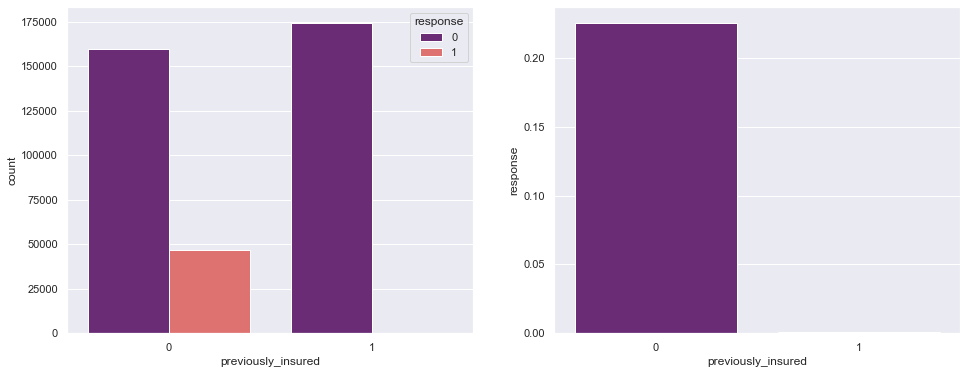

In [38]:
fig = plt.figure(figsize = (16,6))

plt.subplot (1,2,1)
sns.countplot(x = df4['previously_insured'], hue = df4['response'], palette = "magma");

plt.subplot (1,2,2)
aux1 = df4[['previously_insured', 'response']].groupby('previously_insured').mean().reset_index()
sns.barplot (x = 'previously_insured', y = 'response', data = aux1, palette = "magma")

### H9: Customers who use life insurance more, should want auto insurance.
**FALSE.** There is no relationship between when the customer bought their health insurance and interest in car insurance.

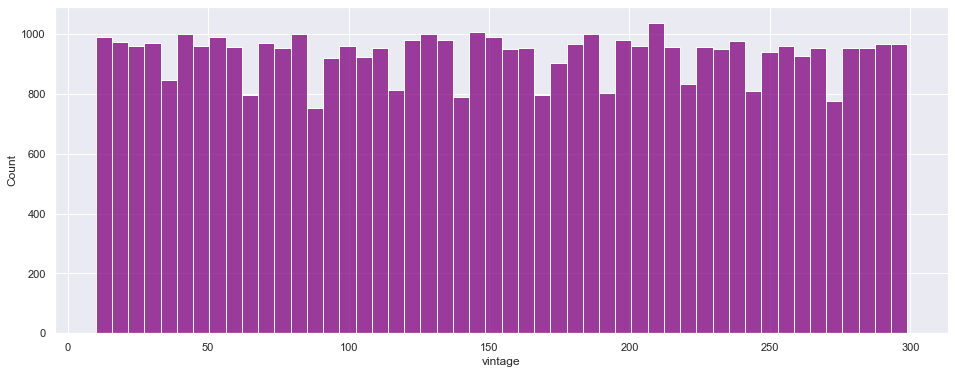

In [39]:
fig = plt.figure(figsize = (16,6))
sns.histplot(x = 'vintage', bins = 50, data = df4[df4['response'] == 1], color = 'purple');

### H10: Customers who live in regions with more demage rate should want auto insurance.
**TRUE.** Customers who live in regions with more demage rate should want auto insurance.

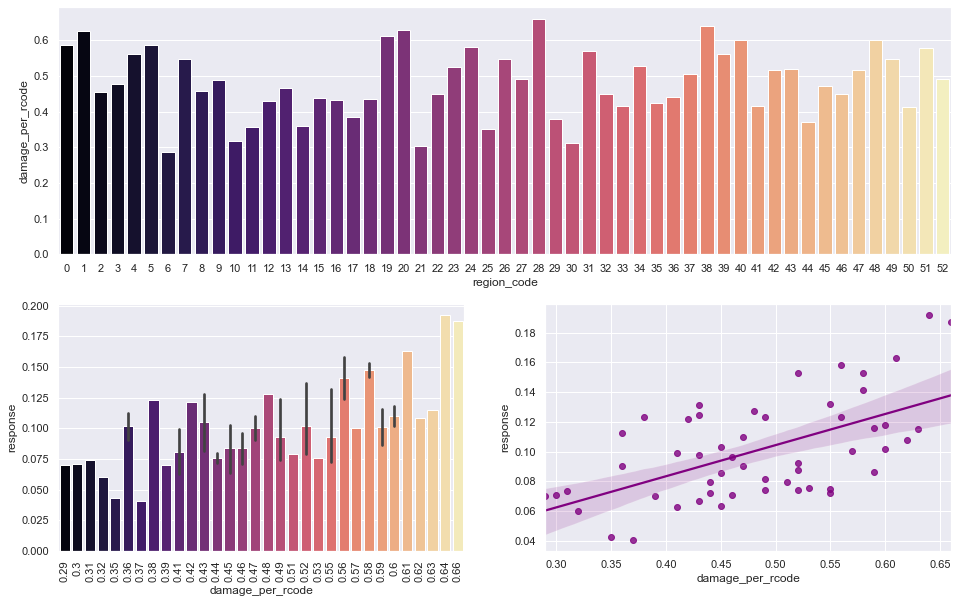

In [40]:
fig = plt.figure(figsize = (16,10))
grid = gridspec.GridSpec(2,2)

plt.subplot (grid[0,:])
aux1 = df4[['region_code', 'damage_per_rcode']].groupby('region_code').mean().reset_index()
sns.barplot(x = 'region_code', y = 'damage_per_rcode', data = aux1, palette = "magma");

plt.subplot (grid[1,0])
aux2 = df4[['damage_per_rcode', 'response']].groupby('damage_per_rcode').mean().reset_index()
aux2['damage_per_rcode'] = aux2['damage_per_rcode'].round(2)
sns.barplot (x = 'damage_per_rcode', y = 'response', data = aux2, palette = "magma");
plt.xticks(rotation = 90);

plt.subplot (grid[1,1])
sns.regplot(x = 'damage_per_rcode', y = 'response', data = aux2, color = 'purple');

### 4.2.1 Hypotheses resume

In [41]:
# display columns complete description
pd.set_option('display.max_colwidth', None)



# Hypothesis Summary dataframe
summary = pd.DataFrame({'Hypothesis':['Older customers should want more a motor ensurance.',
                                      'Female customers should want more a motor ensurance.',
                                      'Customers without drive license should not want a motor ensurance.',
                                      'Customers with high Annual Premium should want more a motor ensurance.',
                                      'Customers that lives on city centers should want more a motor ensurance.',
                                      'Customers that had previous acidents should want more a motor ensurance.',
                                      'Customers who own a newer car should want more auto insurance.',
                                      'Customers that had a previous auto ensurance should want more a motor ensurance.',
                                      'Customers who use life insurance more, should want auto insurance.',
                                      'Customers who live in regions with more demage rate should want auto insurance.'],
                        'True / False':['False', 'False', 'True', 'True', 'True', 'True', 'False', 'False', 'False',
                                        'True'], 
                        'Relevance':['High', 'Low', 'High', 'High', 'Medium', 'High','High', 'Medium', 'Low', 'Medium']}, 
                        index=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
summary

,Hypothesis,True / False,Relevance
1,Older customers should want more a motor ensurance.,False,High
2,Female customers should want more a motor ensurance.,False,Low
3,Customers without drive license should not want a motor ensurance.,True,High
4,Customers with high Annual Premium should want more a motor ensurance.,True,High
5,Customers that lives on city centers should want more a motor ensurance.,True,Medium
6,Customers that had previous acidents should want more a motor ensurance.,True,High
7,Customers who own a newer car should want more auto insurance.,False,High
8,Customers that had a previous auto ensurance should want more a motor ensurance.,False,Medium
9,"Customers who use life insurance more, should want auto insurance.",False,Low
10,Customers who live in regions with more demage rate should want auto insurance.,True,Medium


## 4.3 Multivariate Analysis

In [139]:
# Divide features in numerical, categorical and binary
num_attributes = df4[['age','region_code', 'annual_premium', 'vintage']]
bin_attributes = df4[['driving_license', 'vehicle_damage', 'previously_insured', 'response']]
cat_attributes = df4.select_dtypes(exclude = ['int64', 'int32', 'float64'])

### 4.3.1 Numerical Attributes

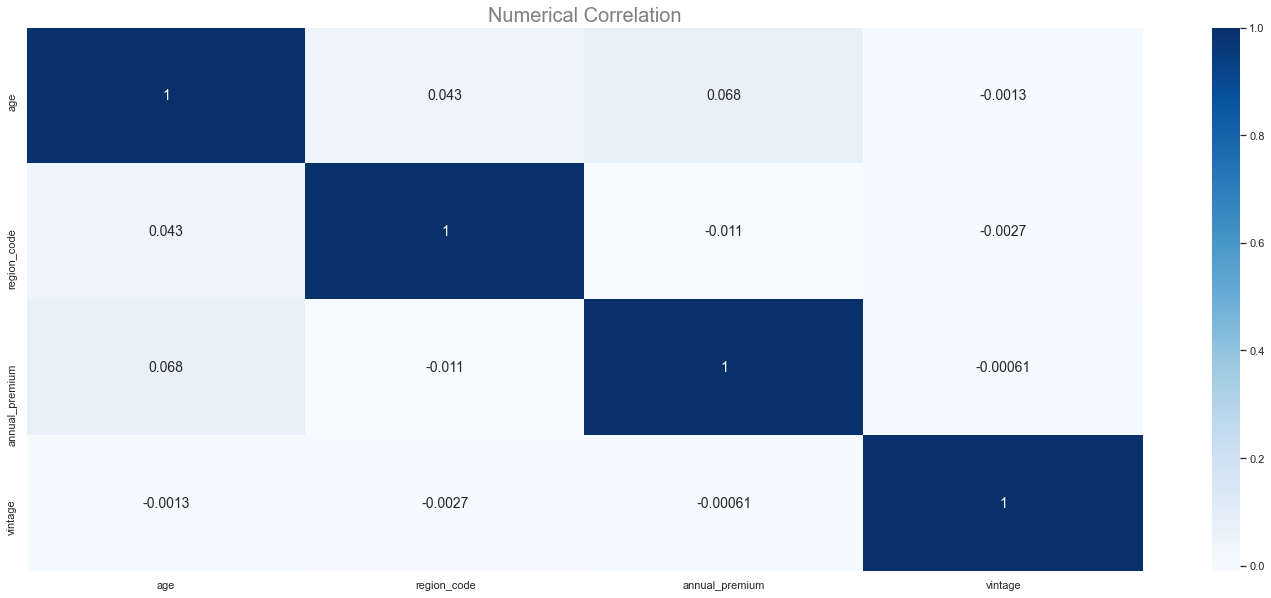

In [140]:
fig = plt.figure(figsize = (25,10))
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot = True, annot_kws={"fontsize":14}, cmap="Blues");
plt.title("Numerical Correlation", size=20, color='gray');

### 4.3.2 Binary x Numerical Attributes

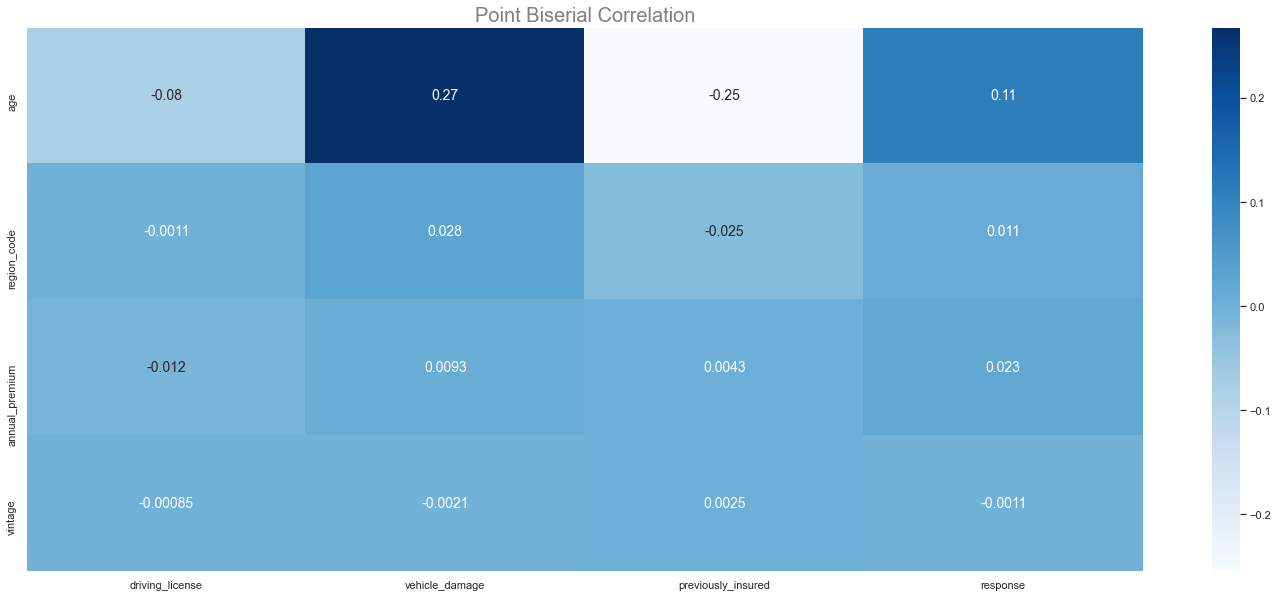

In [46]:
## Only numerical and binary data

# Calculate point bisserial correlation
x1 = pointbiserialr(bin_attributes['driving_license'], num_attributes['age'])[0]
x2 = pointbiserialr(bin_attributes['driving_license'], num_attributes['region_code'])[0]
x3 = pointbiserialr(bin_attributes['driving_license'], num_attributes['annual_premium'])[0]
x4 = pointbiserialr(bin_attributes['driving_license'], num_attributes['vintage'])[0]

x5 = pointbiserialr(bin_attributes['vehicle_damage'], num_attributes['age'])[0]
x6 = pointbiserialr(bin_attributes['vehicle_damage'], num_attributes['region_code'])[0]
x7 = pointbiserialr(bin_attributes['vehicle_damage'], num_attributes['annual_premium'])[0]
x8 = pointbiserialr(bin_attributes['vehicle_damage'], num_attributes['vintage'])[0]

x9 = pointbiserialr(bin_attributes['previously_insured'], num_attributes['age'])[0]
x10 = pointbiserialr(bin_attributes['previously_insured'], num_attributes['region_code'])[0]
x11 = pointbiserialr(bin_attributes['previously_insured'], num_attributes['annual_premium'])[0]
x12 = pointbiserialr(bin_attributes['previously_insured'], num_attributes['vintage'])[0]

x13 = pointbiserialr(bin_attributes['response'], num_attributes['age'])[0]
x14 = pointbiserialr(bin_attributes['response'], num_attributes['region_code'])[0]
x15 = pointbiserialr(bin_attributes['response'], num_attributes['annual_premium'])[0]
x16 = pointbiserialr(bin_attributes['response'], num_attributes['vintage'])[0]

# Final dataset
d = pd.DataFrame({'driving_license':[x1, x2, x3, x4],
                  'vehicle_damage':[x5, x6, x7,x8 ],
                  'previously_insured':[x9, x10, x11, x12],
                  'response': [x13, x14, x15, x16]})

# Sets the index equal to columns
d = d.set_index(num_attributes.columns)

fig = plt.figure(figsize = (25,10))
sns.heatmap(d, annot = True, annot_kws={"fontsize":14}, cmap="Blues");
plt.title("Point Biserial Correlation", size=20, color='gray');

### 4.3.3 Categorical Attributes

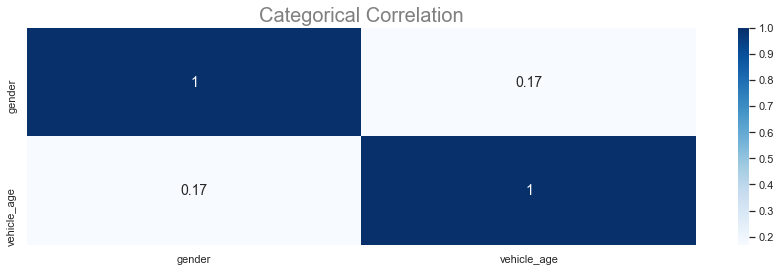

In [52]:
# Only categorical data
a = df4.select_dtypes( include = 'object')

# Calculate cramer v
a1 = cramer_v( a['gender'], a['gender'] )
a2 = cramer_v( a['gender'], a['vehicle_age'] )

a3 = cramer_v( a['vehicle_age'], a['gender'] )
a4 = cramer_v( a['vehicle_age'], a['vehicle_age'] )


# Final dataset
d = pd.DataFrame( {'gender': [a1, a2],
                   'vehicle_age': [a3, a4],})

d = d.set_index(d.columns)

fig = plt.figure(figsize = (15,4))
sns.heatmap(d, annot = True, annot_kws={"fontsize":14}, cmap="Blues");
plt.title("Categorical Correlation", size=20, color='gray');

# 5.0 DATA PREPARATION

In [141]:
df5 = df4.copy()

In [142]:
df5.columns

Index(['id', 'gender', 'age', 'region_code', 'previously_insured',
       'annual_premium', 'vintage', 'driving_license', 'vehicle_age',
       'vehicle_damage', 'response', 'damage_per_rcode'],
      dtype='object')

In [56]:
num_attributes.columns

Index(['age', 'region_code', 'annual_premium', 'vintage'], dtype='object')

## 5.1 Rescaling Features

In [143]:
mms = MinMaxScaler()

# numerical variable different from binary
df5[['id','age', 'region_code', 'annual_premium', 'vintage']] = mms.fit_transform( df5[['id','age', 'region_code', 'annual_premium', 'vintage']])


In [144]:
df5.head()

,id,gender,age,region_code,previously_insured,annual_premium,vintage,driving_license,vehicle_age,vehicle_damage,response,damage_per_rcode
0,0.00002,Male,0.04615,0.21154,0,0.03858,0.82699,1,< 1 Year,1,0,0.35778
1,0.00003,Female,0.32308,0.28846,1,0.05354,0.73010,1,1-2 Year,0,0,0.43816
2,0.00004,Female,0.07692,0.67308,1,0.08184,1.00000,1,< 1 Year,0,0,0.42538
3,0.00008,Female,0.09231,0.15385,0,0.00000,0.43599,1,< 1 Year,0,0,0.45860
4,0.00010,Male,0.38462,0.15385,0,0.07379,0.87889,1,1-2 Year,1,0,0.45860


## 5.2 Features Transformation

### 5.2.1 Encoding

In [145]:
# ORDINAL ENCODING:
# cholesterol
df5["gender"] = df5["gender"].map({"Male": 0, "Female": 1})
# glucose
df5["vehicle_age"] = df5["vehicle_age"].map({"< 1 Year": 0, "1-2 Year": 1, "> 2 Years": 2})

# 6.0 FEATURE SELECTION

In [146]:
df6 = df5.copy()

## 6.1 Split DataFrame into training and test DataSet

In [149]:
cols_drop = ['response']
X = df6.drop(cols_drop, axis = 1)
y = df6['response']

In [150]:
# Split into train (70%), validation (10%) and test (20%)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=28, stratify=y)

# train valid split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.10, random_state=28)

## 6.2 Boruta as Feature selector

In [82]:
# training and test dataset for boruta
#X_train_n = X_train.values
#y_train_n = y_train.values.ravel()

# define RandomForestClassifier
#rf = RandomForestClassifier( n_jobs = -1 )

# define boruta
#boruta = BorutaPy( rf, n_estimators = 'auto', verbose = 2, random_state = 42).fit( X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	8
Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	8
Iteration: 	10 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	8
Iteration: 	11 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	8
Iteration: 	12 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	8
Iteration: 	13 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	8
Iteration: 	14 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	8
Iteration: 	15 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	8
Iteration: 	16 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	8
Iteration:

### 6.2.1 Best Features from Boruta

In [85]:
#cols_selected = boruta.support_.tolist()

# best features
#X_train_fs = X_train
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected Boruta
#cols_not_selected_boruta = list(np.setdiff1d( X_train_fs.columns, cols_selected_boruta ))
#cols_selected_boruta

['age']

Boruta only answered ['age'] as a feature selection. With that we will try other methods.

## 6.3 Random Forest as Feature Selector

In [87]:
rf = RandomForestClassifier(n_estimators=3000, n_jobs=-1)

sfm = SelectFromModel(estimator=rf)
sfm.fit(X_train_fs, y_train)

SelectFromModel(estimator=RandomForestClassifier(n_estimators=3000, n_jobs=-1))

### 6.3.1 Best Features from Random Forest

In [88]:
best_columns = sfm.get_support()
best_columns_rf = X_test.loc[:, best_columns].columns.to_list()

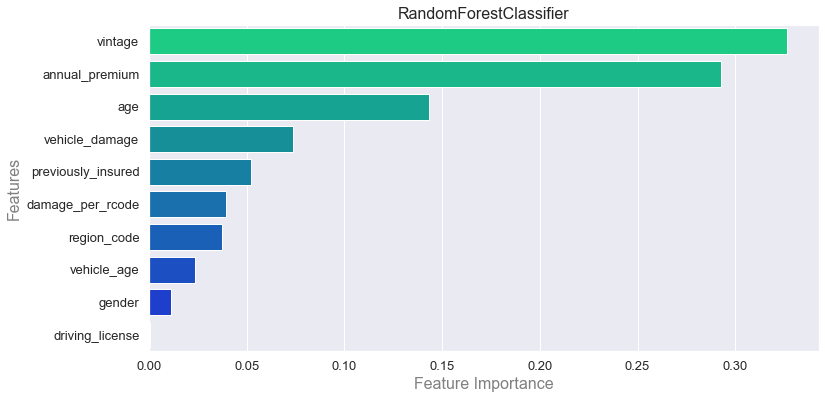

In [93]:
feature_selection(RandomForestClassifier(random_state=28), X, y) 

## 6.4 Manual Feature Selection

In [159]:
cols_selected_rf = ['vintage',
                    'annual_premium',
                    'age',
                    'vehicle_damage',
                    'previously_insured',
                    'damage_per_rcode',
                    'region_code',
                    'vehicle_age',
                    'gender']

# columns to add:
feat_to_add = ['response']

# columns full:
cols_selected_rf_full = cols_selected_rf.copy()
cols_selected_rf_full.extend(feat_to_add)

# 7.0 MACHINE LEARNING MODELLING

## 7.1 Comparing Models Performance

In [157]:
# algorithms
models = [CatBoostClassifier(random_state = 28, verbose = False),
          XGBClassifier(random_state = 28),
          LGBMClassifier(random_state = 28, n_jobs = -1),
          LogisticRegression(max_iter = 220, random_state = 28),
          RandomForestClassifier(random_state = 28),
          BalancedRandomForestClassifier(random_state = 28),
          SGDClassifier(loss = 'log', random_state = 28, n_jobs = -1)]

ml_performance(models, X_train, y_train, X_valid, y_valid, 0.50)

Training CatBoostClassifier...
Training XGBClassifier...
[11:11:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training LGBMClassifier...
Training LogisticRegression...
Training RandomForestClassifier...
Training BalancedRandomForestClassifier...
Training SGDClassifier...


,Model Name,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Kappa,Brier
0,BalancedRandomForestClassifier,0.69865,0.28462,0.92354,0.43514,0.79493,0.30079,0.30135
0,RandomForestClassifier,0.86703,0.37271,0.08481,0.13818,0.53215,0.09606,0.13297
0,CatBoostClassifier,0.87405,0.46667,0.01461,0.02834,0.50611,0.02087,0.12595
0,XGBClassifier,0.87353,0.40000,0.01253,0.02429,0.50491,0.01679,0.12647
0,LGBMClassifier,0.87425,0.41667,0.00130,0.00260,0.50052,0.00182,0.12575
0,SGDClassifier,0.87422,0.28571,0.00052,0.00104,0.50017,0.00058,0.12578
0,LogisticRegression,0.87418,0.00000,0.00000,0.00000,0.49992,-0.00026,0.12582


In [160]:
# algorithms
models = [CatBoostClassifier(random_state = 28, verbose = False),
          XGBClassifier(random_state = 28),
          LGBMClassifier(random_state = 28, n_jobs = -1),
          LogisticRegression(max_iter = 220, random_state = 28),
          RandomForestClassifier(random_state = 28),
          BalancedRandomForestClassifier(random_state = 28),
          SGDClassifier(loss = 'log', random_state = 28, n_jobs = -1)]

ml_performance(models, X_train, y_train, X_valid, y_valid, 0.50)

Training CatBoostClassifier...
Training XGBClassifier...
[15:33:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training LGBMClassifier...
Training LogisticRegression...
Training RandomForestClassifier...
Training BalancedRandomForestClassifier...
Training SGDClassifier...


,Model Name,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Kappa,Brier
0,BalancedRandomForestClassifier,0.69865,0.28462,0.92354,0.43514,0.79493,0.30079,0.30135
0,RandomForestClassifier,0.86703,0.37271,0.08481,0.13818,0.53215,0.09606,0.13297
0,CatBoostClassifier,0.87405,0.46667,0.01461,0.02834,0.50611,0.02087,0.12595
0,XGBClassifier,0.87353,0.40000,0.01253,0.02429,0.50491,0.01679,0.12647
0,LGBMClassifier,0.87425,0.41667,0.00130,0.00260,0.50052,0.00182,0.12575
0,SGDClassifier,0.87422,0.28571,0.00052,0.00104,0.50017,0.00058,0.12578
0,LogisticRegression,0.87418,0.00000,0.00000,0.00000,0.49992,-0.00026,0.12582


## 7.2 Confusion Matrix

[15:28:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


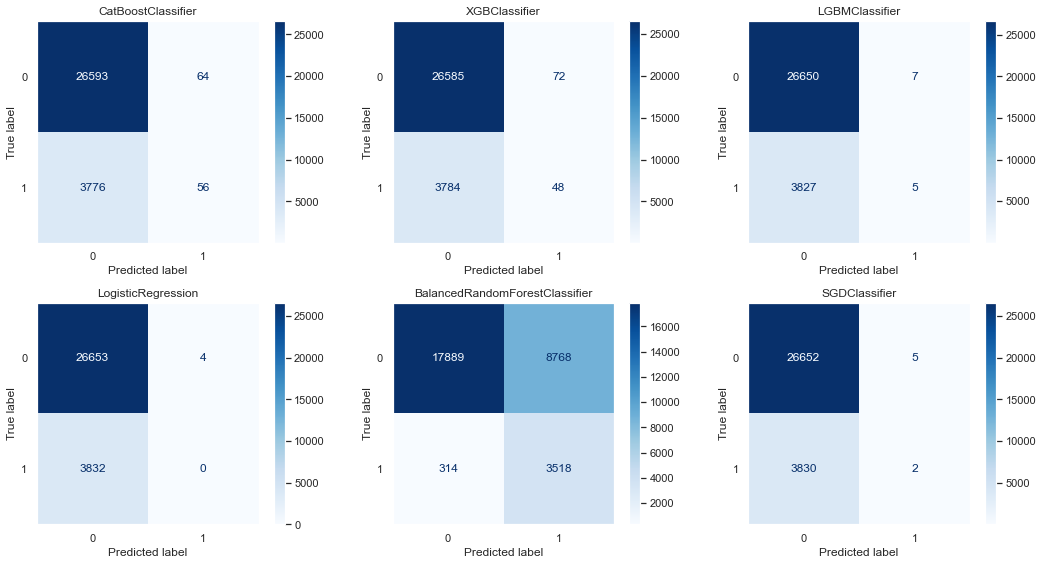

In [158]:
classifiers = [CatBoostClassifier(random_state = 28, verbose = False),
          XGBClassifier(random_state = 28),
          LGBMClassifier(random_state = 28, n_jobs = -1),
          LogisticRegression(max_iter = 220, random_state = 28),
          BalancedRandomForestClassifier(random_state = 28),
          SGDClassifier(loss = 'log', random_state = 28, n_jobs = -1)]

for cls in classifiers:
    cls.fit(X_train, y_train)
    
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,8))

for cls, ax in zip(classifiers, axes.flatten()):
    plot_confusion_matrix(cls, 
                          X_valid, 
                          y_valid, 
                          ax=ax, 
                          cmap='Blues')
    ax.title.set_text(type(cls).__name__)
    ax.grid(False)
plt.tight_layout()  
plt.show()

## 7.3 Probability distribution